In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime ,time 
import time
import plotly.express as px

## import csv

In [7]:
uber = pd.read_csv("../uber_n.csv")

In [8]:
uber.head()

,data
0,11-Aug-22
1,9:16 PM
2,"NGN 3,368.00"
3,Lagos
4,25.53 Kilometers


## Drop NaNs

In [9]:
uber.dropna(inplace=True)

## Search and extract rows for time using the 'AM' and 'PM' strings

In [10]:
uber_t =uber[uber.data.str.contains(' PM') | uber.data.str.contains(' AM')]
uber_t

,data
1,9:16 PM
9,12:19 PM
16,11:03 AM
24,10:01 PM
32,9:53 PM
...,...
3321,7:01 AM
3329,3:44 PM
3337,12:48 PM
3345,10:33 AM


## using the .split() method to extract AM and PM from time.

In [11]:
uber_t = uber_t.data.str.split(expand = True).rename({0: "time",1:'am_pm'},axis=1)

In [12]:
uber_t[:4]

,time,am_pm
1,9:16,PM
9,12:19,PM
16,11:03,AM
24,10:01,PM


## convert to datetime

In [13]:
uber_t['time'] = pd.DatetimeIndex(uber_t.time)
uber_t['tod(hr)'] = pd.DatetimeIndex(uber_t.time).hour
uber_t.head(3)

,time,am_pm,tod(hr)
1,2022-08-31 09:16:00,PM,9
9,2022-08-31 12:19:00,PM,12
16,2022-08-31 11:03:00,AM,11


# lets classifiy the time into "morning", "afternoon", "evening", "night

In [14]:
def func_tod(x):
    if (x>=0) & (x<6):
        tod = 'night'
    elif (x>=6) & (x<12):
        tod = 'morning'
    elif (x>=12) & (x<18):
        tod = 'afternoon'
    else:
        tod = 'evening'
    return tod

In [15]:
uber_t['tod_class'] = uber_t['tod(hr)'].apply(lambda x: func_tod(x))

In [16]:
uber_t.sample(5)

,time,am_pm,tod(hr),tod_class
401,2022-08-31 04:20:00,PM,4,night
341,2022-08-31 12:42:00,PM,12,afternoon
2110,2022-08-31 06:28:00,PM,6,morning
2907,2022-08-31 02:31:00,PM,2,night
393,2022-08-31 06:03:00,PM,6,morning


## feature extraction for price using the NGN (Nigerian currency)

In [17]:
uber['price'] = uber['data'].str.contains('NGN')

In [18]:
uber_price = uber[uber.price == True]

In [19]:
uber_price = uber_price.drop('price',axis =1).rename({"data":"price"},axis =1)
uber_price.head()

,price
2,"NGN 3,368.00"
10,NGN 0.00
17,"NGN 1,600.00"
25,"NGN 1,000.00"
33,NGN 0.00


## using the regex and .split() method to extract the NGN , comma and period

In [20]:
stripped_price = uber_price.price.str.replace(r"\,","").str.replace(r"\.00","")

C:\Users\godwi\AppData\Local\Temp\ipykernel_12528\4112769728.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  stripped_price = uber_price.price.str.replace(r"\,","").str.replace(r"\.00","")


In [21]:
stripped_price= stripped_price.str.split(expand=True)[1]

In [22]:
stripped_price

2       3368
10         0
17      1600
25      1000
33         0
        ... 
3322       0
3330    2300
3338       0
3346       0
3352       0
Name: 1, Length: 433, dtype: object

## Feature extraction for rows with distance using the Kilometers.

In [23]:
uber['distance'] = uber['data'].str.contains('Kilometers')

In [24]:
uber_distance = uber[uber.distance == True]

In [25]:
uber_distance = uber_distance.drop(['price','distance'],axis =1)

In [26]:
uber_distance =uber_distance.rename({"data":"distance"},axis=1)
uber_distance.head()

,distance
4,25.53 Kilometers
12,0.00 Kilometers
19,11.11 Kilometers
27,3.43 Kilometers
35,0.00 Kilometers


## using the .split() method to extract distance using the tag "distance"

In [27]:
ride_distance = uber_distance.distance.str.split(expand = True, n= 2)[0]
ride_distance

4       25.53
12       0.00
19      11.11
27       3.43
35       0.00
        ...  
3324     0.00
3332    18.01
3340     0.00
3348     0.00
3354     0.00
Name: 0, Length: 433, dtype: object

## Concat both price , distance, time dataframes, also reseting index - so they are common

In [28]:
rides =pd.concat([stripped_price.reset_index(), ride_distance.reset_index(),uber_t.reset_index()],axis = 1,join='outer')\
    .reset_index().drop(['index','level_0'], axis =1).rename({1:"price", 0:'distance'},axis =1)
rides

,price,distance,time,am_pm,tod(hr),tod_class
0,3368,25.53,2022-08-31 09:16:00,PM,9,morning
1,0,0.00,2022-08-31 12:19:00,PM,12,afternoon
2,1600,11.11,2022-08-31 11:03:00,AM,11,morning
3,1000,3.43,2022-08-31 10:01:00,PM,10,morning
4,0,0.00,2022-08-31 09:53:00,PM,9,morning
...,...,...,...,...,...,...
430,0,0.00,2022-08-31 07:01:00,AM,7,morning
431,0,0.00,2022-08-31 03:44:00,PM,3,night
432,0,0.00,2022-08-31 12:48:00,PM,12,afternoon
433,NaN,NaN,2022-08-31 10:33:00,AM,10,morning


## change the data types

In [29]:
rides = rides.astype({'price' : 'float','distance':'float' })
rides.dtypes

price               float64
distance            float64
time         datetime64[ns]
am_pm                object
tod(hr)               int64
tod_class            object
dtype: object

# Final data frame

In [30]:
rides

,price,distance,time,am_pm,tod(hr),tod_class
0,3368.0,25.53,2022-08-31 09:16:00,PM,9,morning
1,0.0,0.00,2022-08-31 12:19:00,PM,12,afternoon
2,1600.0,11.11,2022-08-31 11:03:00,AM,11,morning
3,1000.0,3.43,2022-08-31 10:01:00,PM,10,morning
4,0.0,0.00,2022-08-31 09:53:00,PM,9,morning
...,...,...,...,...,...,...
430,0.0,0.00,2022-08-31 07:01:00,AM,7,morning
431,0.0,0.00,2022-08-31 03:44:00,PM,3,night
432,0.0,0.00,2022-08-31 12:48:00,PM,12,afternoon
433,NaN,NaN,2022-08-31 10:33:00,AM,10,morning


## Perform Statistics description of both price and distance

In [31]:
rides.describe()

,price,distance,tod(hr)
count,433.000000,433.000000,435.000000
mean,742.939954,5.938845,6.374713
std,988.162256,8.235563,3.489260
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,6.000000
75%,1400.000000,11.490000,9.000000
max,5600.000000,43.500000,12.000000


In [32]:
rides.price.sum()

321693.0

## How many completed uber trips ie not equal to zero km

In [33]:
rides[rides.price != 0].value_counts().sum()

208

c:\Users\godwi\anaconda3\envs\ML\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price', ylabel='distance'>

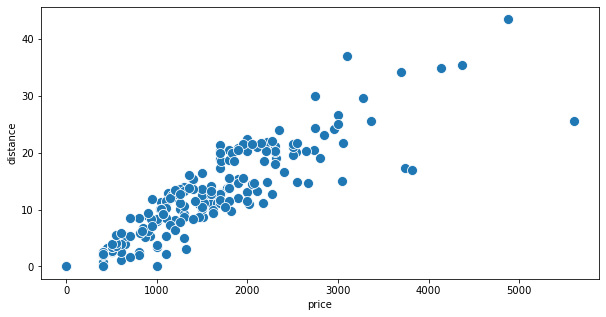

In [34]:
fig,ax =plt.subplots(figsize = (10,5))
sns.scatterplot(rides.price, rides.distance,ax=ax, s = 100)

# what time of the day was most trip

In [35]:
fig=px.bar(rides.tod_class, orientation='h' )
fig.update_layout(width=700)
fig.show()

c:\Users\godwi\anaconda3\envs\ML\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='tod_class', ylabel='count'>

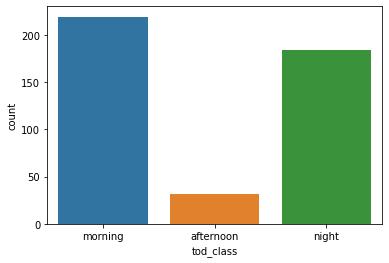

In [36]:
sns.countplot(rides.tod_class, )

In [37]:
print("thank you")

thank you


# The data is very linear, but I wish to play around with clustering . You might ignore

In [38]:
# label encode the day of week
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [39]:
rides['tod_class_encode'] = le.fit_transform(rides.tod_class)

In [40]:
rides_completed = rides[rides.distance != 0].iloc[:,[0,1,4,6]]
rides_completed 


,price,distance,tod(hr),tod_class_encode
0,3368.0,25.53,9,1
2,1600.0,11.11,11,1
3,1000.0,3.43,10,1
5,1514.0,8.76,4,2
6,1669.0,11.19,2,2
...,...,...,...,...
426,1250.0,7.85,9,1
427,3050.0,21.70,4,2
429,2300.0,18.01,7,1
433,NaN,NaN,10,1


In [41]:
rides_completed = rides_completed.dropna()
rides_completed

,price,distance,tod(hr),tod_class_encode
0,3368.0,25.53,9,1
2,1600.0,11.11,11,1
3,1000.0,3.43,10,1
5,1514.0,8.76,4,2
6,1669.0,11.19,2,2
...,...,...,...,...
424,2850.0,23.10,1,2
425,1200.0,6.45,8,1
426,1250.0,7.85,9,1
427,3050.0,21.70,4,2


In [42]:
# normalize the data with standard scaler
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
rc_scaled = sc.fit_transform(rides_completed)
rc_scaled[:10]

array([[ 2.03917892,  1.67547114,  0.77943516, -0.56796183],
       [ 0.04676489, -0.1850166 ,  1.37342849, -0.56796183],
       [-0.62939372, -1.17590051,  1.07643182, -0.56796183],
       [-0.05015118, -0.48821676, -0.70554818,  1.09535497],
       [ 0.12452313, -0.1746949 , -1.29954152,  1.09535497],
       [ 0.06704965, -0.33339115, -1.59653818,  1.09535497],
       [ 2.9102966 ,  2.88182069, -0.70554818,  1.09535497],
       [ 1.32695852,  1.03036444,  0.48243849, -0.56796183],
       [ 1.22666166,  1.00197974,  1.37342849, -0.56796183],
       [ 0.9483097 ,  0.52589099, -0.40855151,  1.09535497]])

In [43]:
# lets use pca to reduce the features 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [44]:
pca = PCA(n_components= 2)
rc_scaled_pca = pca.fit_transform(rc_scaled)
rc_scaled_pca = pd.DataFrame(rc_scaled_pca, columns=['pca1','pca2'])
rc_scaled_pca

,pca1,pca2
0,2.504160,1.235557
1,0.918654,-1.020014
2,-0.053174,-1.720438
3,-1.185731,0.612996
4,-1.247431,1.151630
...,...,...
200,0.009509,2.756102
201,-0.052425,-1.117445
202,0.216257,-1.143645
203,0.481117,2.346040


In [45]:
pca.explained_variance_ratio_.cumsum()

array([0.48355399, 0.9419396 ])

# plot elbow to deternine optimum number of clusters

In [46]:
from sklearn.cluster import KMeans

In [47]:
wcss = []
for i in range(1,10):
    km = KMeans(n_clusters=i)
    km.fit(rc_scaled_pca)
    wcss_iter = km.inertia_
    wcss.append(wcss_iter)
    

# plot the wcss

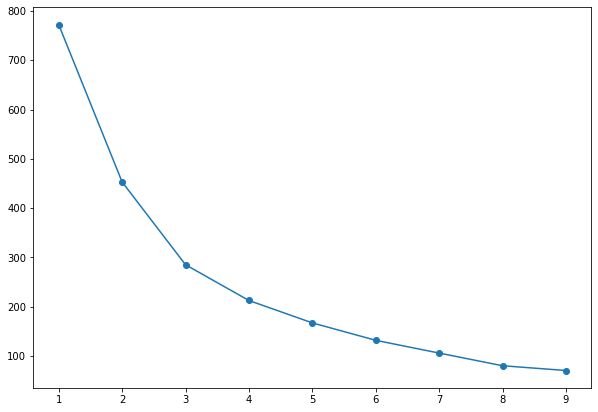

In [48]:
fig, ax = plt.subplots(figsize = (10,7))
plt.plot(range(1,10),wcss, marker ='o')
plt.show()

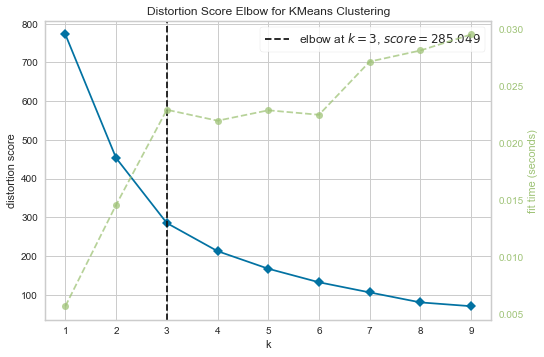

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [49]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10)).fit(rc_scaled_pca)
visualizer.show()

In [50]:
kmeans = KMeans(n_clusters=3, random_state = 42)
kmeans.fit_transform(rc_scaled_pca )
final_kmeans = pd.concat([rc_scaled_pca, pd.DataFrame({'clusters' : kmeans.labels_})],axis = 1)
final_kmeans

,pca1,pca2,clusters
0,2.504160,1.235557,0
1,0.918654,-1.020014,2
2,-0.053174,-1.720438,2
3,-1.185731,0.612996,1
4,-1.247431,1.151630,1
...,...,...,...
200,0.009509,2.756102,0
201,-0.052425,-1.117445,2
202,0.216257,-1.143645,2
203,0.481117,2.346040,0


In [51]:
# inverse the scaled data
rescaled = pd.DataFrame(sc.inverse_transform(rc_scaled))
rescaled
columns = rides_completed.columns.values
rescaled.columns=columns

In [52]:
clustered = pd.concat([rescaled,final_kmeans.clusters],axis=1)
clustered

,price,distance,tod(hr),tod_class_encode,clusters
0,3368.0,25.53,9.0,1.0,0
1,1600.0,11.11,11.0,1.0,2
2,1000.0,3.43,10.0,1.0,2
3,1514.0,8.76,4.0,2.0,1
4,1669.0,11.19,2.0,2.0,1
...,...,...,...,...,...
200,2850.0,23.10,1.0,2.0,0
201,1200.0,6.45,8.0,1.0,2
202,1250.0,7.85,9.0,1.0,2
203,3050.0,21.70,4.0,2.0,0


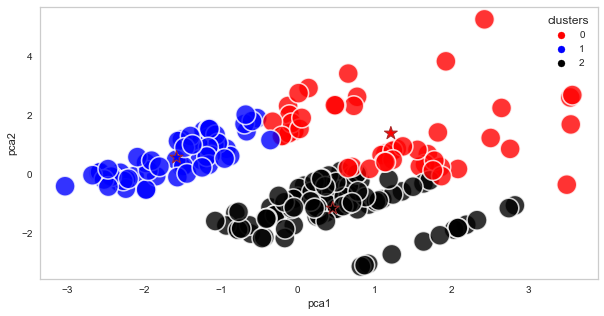

In [54]:
fig,ax = plt.subplots(figsize = (10,5))
sns.scatterplot(data = final_kmeans, x='pca1', y ='pca2', palette= ['red', 'blue','black'],\
    hue = 'clusters',alpha=0.8, s = 400)
sns.scatterplot(x= kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], 
    hue= range(3), palette= ['red', 'blue','black'], s=180, ec='brown', marker = "*",  legend = False, ax=ax)
plt.grid()